## In-Painting

In the first two tutorials, we saw how we can use Ledidi to design transcription factor binding sites by pairing it with a machine learning model, and then we saw how we can add hard and soft constraints to guide the designs using domain knowledge. However, masks and priors only cover certain forms of domain knowledge where you have precise knowledge of that cannot or must happen (and the soft versions). What about when you are less sure about what should happen in a region and you want to indicate that lack of certainty?

In-painting is a form of design where sections of the sequence are removed entirely and Ledidi is tasked with "filling in" the region in accordance with the target outcome. In these sections, you do not care about the identity of the nucleotides in the design or even that they match the initial characters as closely as possible, so long as the design in its entiry achieve the target outcome. Put another way, these spans are free edits that can be used without suffering the input loss penalty making in-painting the conceptual opposite of masking. Because these edits are free, they are preferentially used to achieve the target outcome, but edits can still be made outside the in-painting window if needed. The name comes from computer vision where crops of images would be removed and the algorithms would be tasked with "painting in" the missing region, or "in-painting" if you want to sound fancy. 

There are three main use-cases where in-painting can be useful. The first is when you know roughly *where* you want motifs to be inserted but do not know exactly what the motif or combinations of motifs should be but you do know what you want the outcome to be. The second is when you know that you want to delete some element but you do not know what to replace it with. Finally, the third is when you want to move a motif but you want to make sure the affinity and context yield e.g. the same binding as before. In both cases, you can use Ledidi to figure out how these regions should be filled in.

Let's see this in action using the same model we have been using so far: a BPNet model predicting GATA2 binding.

In [1]:
import torch

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

model = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
model = CountWrapper(ControlWrapper(model)).cuda()

#### Adding in Motifs to Background Sequence (GATA2)

The first main use-case of in-painting can be thought of as "off" to "on," in that you are taking a region that is thought to be irrelevant for the design objective and having Ledidi focus its design efforts there. This setting requires domain knowledge of what regions are truly irrelevant because, when using in-painting, there is no reward at all for keeping the initial sequence within these spans. But if you have this knowledge, it is a great and practical way of limiting off-target effects by focusing Ledidi's edits in a targetted manner.

We can use the same SMYD3 promoter as in our other tutorials.

In [2]:
import pyfaidx
from tangermeme.utils import one_hot_encode

chrom, mid = 'chr1', 246507312 # Location of the SMYD3 gene
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X).unsqueeze(0).float().cuda()

Let's say that we wanted to block out a chunk of 20bp upstream from the TSS and did not really care where exactly the GATA motifs were within it or even what else might be added in. Potentially, the nucleotides here are just spacing or otherwise known to be irrelevant. In practice, one should be pretty careful about their designs in a promoter region but this is just an example to demonstrate.

All we have to do to use in-painting is to zero out that portion of the sequence we want to remove and then running Ledidi normally. Essentially, because Ledidi must sample a character at every position, *any* character will impose the same input loss so Ledidi preferentially chooses characters that also decrease the output loss. As a technical note, the input loss for these regions is adjusted down to zero to make the optimization problem more stable, but conceptually the idea still holds. Something to keep in mind is that this means that any Ns in your initial sequence will be considered targets for in-painting. This is not a problem, necessarily, but just means that Ns in the initial sequence will not be preserved in the designed sequence.

In [3]:
mid = 1057

Xip = torch.clone(X)
Xip[:, :, mid+20:mid+40] = 0

Now, let's run Ledidi with and without inpainting and look at where edits are made.

In [4]:
from tangermeme.predict import predict
from ledidi import ledidi

y_bar = predict(model, X).cuda() + 2

torch.manual_seed(0)
X_bar0 = ledidi(model, X, y_bar)

print()

torch.manual_seed(0)
X_bar1 = ledidi(model, Xip, y_bar)

iter=I	input_loss=0.0	output_loss= 4.0	total_loss= 4.0	time=0.0
iter=100	input_loss=12.81	output_loss=0.126	total_loss=1.407	time=2.312
iter=200	input_loss=11.06	output_loss=0.02843	total_loss=1.135	time=1.18
iter=F	input_loss=8.125	output_loss=0.07672	total_loss=0.8892	time=3.988

iter=I	input_loss=0.0	output_loss=2.951	total_loss=2.951	time=0.0
iter=100	input_loss=0.0625	output_loss=0.001094	total_loss=0.007344	time=1.174
iter=200	input_loss=0.1875	output_loss=0.01159	total_loss=0.03034	time=1.188
iter=F	input_loss= 0.0	output_loss=0.001706	total_loss=0.001706	time=2.422


Just looking at the losses we can see a big difference. In both cases the output loss is decreased significantly. However, perhaps even counterintuitively, the output loss is lower when using in-painting despire the input loss *also* being lower. Why? Well, Ledidi was given a 20bp window to make whatever sort of edits it would like without incurring any input loss. This means that it can design the best site and surrounding context to precisely match the target output, whereas the original design task had to balance matching the precise value of 2 with not making too many edits.

We can now visualize where these edits are being made along the sequence.

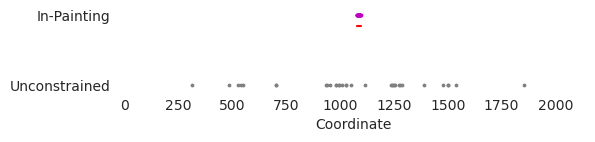

In [5]:
import numpy
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

%matplotlib inline

edits_mask0 = torch.abs(X_bar0 - X[:, None]).sum(dim=(1, 2)).numpy(force=True)
edits_mask0 = numpy.where(edits_mask0 > 0)[1]

edits_mask1 = torch.abs(X_bar1 - X[:, None]).sum(dim=(1, 2)).numpy(force=True)
edits_mask1 = numpy.where(edits_mask1 > 0)[1]


plt.figure(figsize=(6, 1))
plt.plot([1077, 1097], [0.85, 0.85], c='r')
plt.scatter(edits_mask0, numpy.zeros_like(edits_mask0), s=3, c='0.5')
plt.scatter(edits_mask1, numpy.ones_like(edits_mask1), s=3, c='m')

plt.xlim(-20, 2140)
plt.grid(False)
seaborn.despine(bottom=True, left=True)
plt.yticks(range(2), ['Unconstrained', 'In-Painting'])
plt.xlabel("Coordinate")
plt.show()

As expected, it looks like when the edits are unconstrained they are made throughout the entire sequence, likely pushing regions that are almost GATA motifs into those that now strong ones. In contrast, when using in-painting, the edits end up being entirely within the in-painting window (denoted by the red line). Remember that Ledidi is not forced to do this. It can still make edits wherever it wants -- and when given complex objectives or a small enough in-painting window it will -- but the input loss will be lower if it makes use of the free space that it has in that window. 

Now, we can zoom in to that window and see what the actual edits being proposed are.

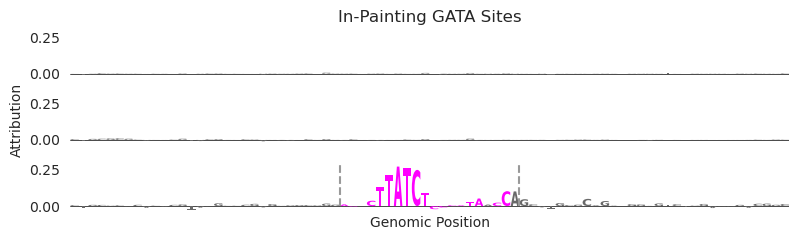

In [6]:
from tangermeme.deep_lift_shap import deep_lift_shap
from ledidi.plot import plot_edits

start, end = 1047, 1127

X_attr0 = deep_lift_shap(model, X)
X_attr1 = deep_lift_shap(model, X_bar0)
X_attr2 = deep_lift_shap(model, X_bar1)

xa0 = X_attr0[:, :, start:end]
xa1 = X_attr1[:1, :, start:end]
xa2 = X_attr2[:1, :, start:end]

axs = plot_edits(xa0, [xa1, xa2], colors=['k', 'darkorange', 'magenta'], figsize=(8, 2.5))
axs[0].set_title("In-Painting GATA Sites")
axs[1].set_ylabel("Attribution")
axs[2].plot([29.5, 29.5], [0, 0.4], linestyle='--', c='0.6')
axs[2].plot([49.5, 49.5], [0, 0.4], linestyle='--', c='0.6')

plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

Each plot is showing attribution values in the window surrounding the selected in-painting window (denoted by the dashed bars in the bottom row). The top row are the initial attributions for GATA at this site in the promoter, the middle row are the attributions in the unconstrained setting, and the bottom row are the attributions when using in-painting. As you might expect, there are significantly more "edits" in the in-painting row than the others because the original sequence does not factor into what sequence is proposed there. It is actually only by chance that some nucleotides happen to be the same character!

However, the more important point is that when doing in-painting, the edits ended up within the selected window without being forced to be there, they correspond to the biologically meaningful GATA motif that we expect would increase model predictions, and that this procedure is quite literally as easily for the user as using Ledidi normally.

#### Removing a Binding Site (SP-1 + Chromatin Accessibility)

Our first example involved taking a region that was considered "off" and turning it into a region that was considered "on." The natural opposite of this is to take some region that is considered "on" and turn it off. However, if all we wanted to do was, e.g., destroy protein binding, we could just shuffle the motif or even use Ledidi with an appropriate predictive model. Here, we want to eliminate a binding site while preserving some other characteristic of the sequence, even if that characteristic arose in-part because of this binding site. 

As a concrete example, let's consider an accessible site whose accessibility is driven the binding of several proteins. If we wanted to eliminate the binding of one of them -- perhaps because that protein is not cell type-specific enough or has some other undesirable property -- we may also want to preserve the overall accessibility of the region. The design task at this point becomes "remove some user-defined protein binding site while preserving chromatin accessibility." Potentially, this involves swapping some other motif in to the region. But, what motif should we swap in? Should it be at maximum affinity or some sub-optimal affinity in order to match the influence of the first protein? Although we might initially expect that we could swap the other motif in where the old motif used to be, maybe there is some other positioning that is better. All of these questions can be solved with a design method like Ledidi.

Let's start off by loading a ChromBPNet model, which makes predictions for chromatin accessibility, and analyzing the same SMYD3 promoter region as before.

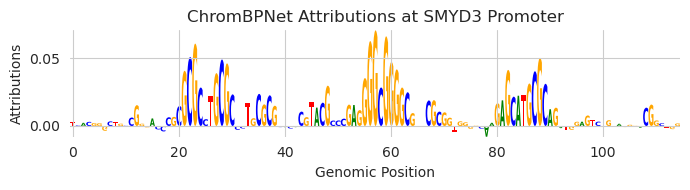

In [7]:
from bpnetlite import BPNet
from tangermeme.plot import plot_logo

chrombpnet = BPNet.from_chrombpnet("../../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet)

X_attr0 = deep_lift_shap(chrombpnet, X).numpy(force=True)

plt.figure(figsize=(7, 2))
ax = plt.subplot(111)
plot_logo(X_attr0[0], ax=ax, start=1015, end=1130)

plt.xlabel("Genomic Position")
plt.ylabel("Attributions")
plt.title("ChromBPNet Attributions at SMYD3 Promoter")
plt.tight_layout()
plt.show()

Looks like there are a few binding sites that are driving accessibility, including a SP1 motif in the middle. Let's make our design task to preserve the exact same chromatin accessibility predictions as before but to erase that SP1 motif. We can do this with in-painting by simply slicing out that motif.

In [8]:
Xip2 = torch.clone(X)
Xip2[:, :, 1055:1085] = 0  # Remove the SP1 motif

y_bar = predict(chrombpnet, X).cuda()  # Set the goal to be to keep predictions the same

Now, just as before, we can use Ledidi in exactly the same manner.

In [9]:
X_bar1 = ledidi(chrombpnet, Xip2, y_bar)

iter=I	input_loss=0.0	output_loss=0.1986	total_loss=0.1986	time=0.0
iter=100	input_loss=0.1875	output_loss=0.02927	total_loss=0.04802	time=32.99
iter=F	input_loss= 0.0	output_loss=0.004083	total_loss=0.004083	time=46.81


Looking at the input loss, we can see that no edits have been proposed outside the inpainting region but that the output loss has significantly decreased. Basically, Ledidi was able to fill in the in-painting region with edits that preserved the accessibility.

Now, let's take a look at what Ledidi put in.

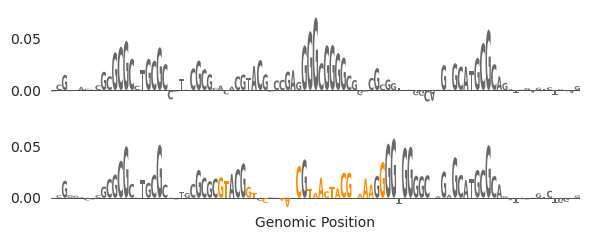

In [10]:
start, end = 1025, 1120

X_attr0 = deep_lift_shap(chrombpnet, X)
X_attr1 = deep_lift_shap(chrombpnet, X_bar1[0:1])

xa0 = X_attr0[:, :, start:end]
xa1 = X_attr1[:, :, start:end]

ax = plot_edits(xa0, [xa1], figsize=(6, 2.5))
axs[0].set_title("In-Painting GATA Sites")
axs[1].set_ylabel("Attribution")
axs[1].plot([29.5, 29.5], [0, 0.4], linestyle='--', c='0.6')
axs[1].plot([59.5, 59.5], [0, 0.4], linestyle='--', c='0.6')

plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

I thought this example was very funny but also a warning to people that they need to check their designs thoroughly after they have been produced, regardless of the method. It does look like a weak affinity site was added in on the left hand side of the in-painting window, but the main thing that happened is that a single G was added on the right hand side of the window that coincidentally happened to be next to another SP-1 site, which became activated due to that G. Basically.. we eliminated the SP-1 motif but it got added back right next to where the original was because BY CHANCE there happened to be an almost-SP-1 motif right there. I swear this arose by chance and I did not plan for it to happen.

Let's try that again but make the window a little smaller to prevent that from happening.

iter=I	input_loss=0.0	output_loss=0.4302	total_loss=0.4302	time=0.0
iter=100	input_loss= 3.0	output_loss=0.007935	total_loss=0.3079	time=15.55
iter=F	input_loss=1.062	output_loss=0.006447	total_loss=0.1127	time=27.98


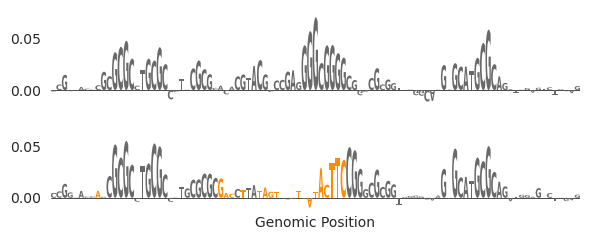

In [11]:
Xip3 = torch.clone(X)
Xip3[:, :, 1055:1079] = 0  # Remove the SP-1 motif

X_bar2 = ledidi(chrombpnet, Xip3, y_bar)

X_attr2 = deep_lift_shap(chrombpnet, X_bar2[0:1])

xa0 = X_attr0[:, :, start:end]
xa2 = X_attr2[:, :, start:end]

ax = plot_edits(xa0, [xa2], figsize=(6, 2.5))
axs[0].set_title("In-Painting GATA Sites")
axs[1].set_ylabel("Attribution")
axs[1].plot([29.5, 29.5], [0, 0.4], linestyle='--', c='0.6')
axs[1].plot([59.5, 59.5], [0, 0.4], linestyle='--', c='0.6')

plt.xlabel("Genomic Position")
plt.tight_layout()
plt.show()

Okay, that looks better. Seems like the SP-1 motif in the middle was removed and it was replaced with something that looks like either an NRF or an EGR motif slightly to its right. like the G-rich site in the middle has been eliminated and instead we have new motifs that are high attribution. Through in-painting, we were able to eliminate a motif and replace it with another motif that preserved the accessibility.

Something to note, though, is that we did not explicitly tell Ledidi here to eliminate the SP-1 motif and it could have simply re-proposed the motif at the original site or shifted over within the mask (as we sort of saw initially). There are at least two ways to prevent this. First, we can use a combination of masking out the specific characters of the SP-1 motif and only in-painting the exact span, as opposed to having the span be wider than the motif as it was here. Second, we could jointly use a chromatin accessibility model tasked with keeping accessibility the same and an SP-1 model tasked with eliminating the binding of SP-1. This option may be a little trickier if your goal were not to eliminate SP-1 binding *anywhere* per-se, but rather just at this specific site, or if a model is not readily available for this sort of binding. You can read more about using multiple models simultaneously in a later tutorial.

#### Moving Motifs (CTCF + Transcription)

In our third setting we would like to move a binding site. This can happen when you want to retain the binding of a certain protein but the specific location it is binding is problematic. For instance, there is a CTCF binding site just downstream of the SMYD3 TSS. Whenever there is anything just after the TSS of a gene -- and especially when that thing is CTCF since it is so bulky -- transcription is reduced. If we wanted an easy way to increase SMYD3 transcription we could try to get rid of this site. However, because CTCF plays such an important role in organizing chromatin architecture, we probably do not want to simply delete the motif.

Rather, we would like to move the CTCF site to somewhere else. In theory, this allows us to maintain chromatin architecture (which likely will not care about CTCF binding moving a few hundred bp) while removing the obstacle to transcription. Accordingly, our design task is made up of three components: in-painting to remove the CTCF moving, in-painting to clear a landing pad for where we would a CTCF site to be added somewhere, and a design objective whose goal is to maintain CTCF levels from the original sequence after moving the site.

Let's load up the CTCF model and take a look at the SMYD3 promoter.

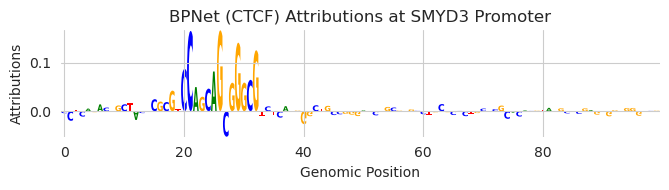

In [12]:
model = torch.load("../../../../models/bpnet/CTCF.torch", weights_only=False)
model = CountWrapper(ControlWrapper(model)).cuda()

X_attr0 = deep_lift_shap(model, X).numpy(force=True)

plt.figure(figsize=(7, 2))
ax = plt.subplot(111)
plot_logo(X_attr0[0], ax=ax, start=980, end=1080)

plt.xlabel("Genomic Position")
plt.ylabel("Attributions")
plt.title("BPNet (CTCF) Attributions at SMYD3 Promoter")
plt.tight_layout()
plt.show()

Now, let's find a region a few hundred bp downstream that are not driving accessibility so we do not disturb something else. It is true that accessibility is not the only thing that protein binding contributes to so this is not a perfect way of looking for inactive regions, but it is a good enough approximation for now.

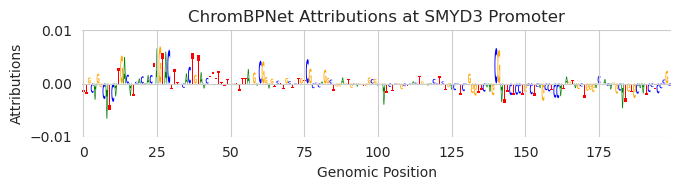

In [13]:
X_attr0 = deep_lift_shap(chrombpnet, X).numpy(force=True)

plt.figure(figsize=(7, 2))
ax = plt.subplot(111)
plot_logo(X_attr0[0], ax=ax, start=1400, end=1600)

plt.xlabel("Genomic Position")
plt.ylabel("Attributions")
plt.title("ChromBPNet Attributions at SMYD3 Promoter")
plt.ylim(-0.01, 0.01)
plt.tight_layout()
plt.show()

If you consider the magnitude of the attributions, it does not look like much is happening here.

We can set up our in-painting task as follows. First, we remove the CTCF site that we originally found, and second, we remove a random region from the above window. To try to incentive Ledidi to place the CTCF site in the inactive region and not just put it back where it found it, we can make the second site a much larger landing pad to give it more space to work with.

In [14]:
Xip3 = torch.clone(X)
Xip3[:, :, 1000:1012] = 0  # Remove the CTCF motif
Xip3[:, :, 1500:1550] = 0

y_bar = predict(model, X).cuda()  # Set the goal to be to keep predictions the same

Despite this being an in-painting task that involves two spans instead of one, using Ledidi is exactly the same.

In [15]:
X_bar3 = ledidi(model, Xip3, y_bar)

iter=I	input_loss=0.0	output_loss=1.73	total_loss=1.73	time=0.0
iter=100	input_loss=0.125	output_loss=0.0005559	total_loss=0.01306	time=1.183
iter=200	input_loss= 1.0	output_loss=0.001895	total_loss=0.1019	time=1.181
iter=F	input_loss= 0.0	output_loss=6.072e-05	total_loss=6.072e-05	time=2.39


Looks like we were able to achieve a very low output loss with zero input loss. This means that a CTCF motif has been added somewhere in one of the two in-painting regions. We can look at both regions before and after editing to see what happened.

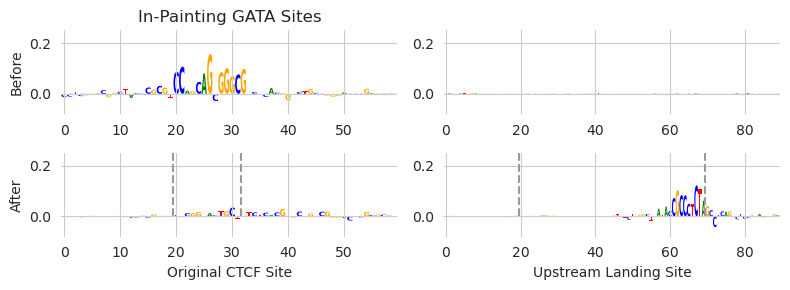

In [16]:
X_attr0 = deep_lift_shap(model, X).numpy(force=True)
X_attr1 = deep_lift_shap(model, X_bar3[0:1]).numpy(force=True)

xa0 = X_attr0[0, :, 980:1040]
xa1 = X_attr1[0, :, 980:1040]
xa2 = X_attr0[0, :, 1480:1570]
xa3 = X_attr1[0, :, 1480:1570]

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 3))
plot_logo(xa0, ax=axs[0, 0])
plot_logo(xa1, ax=axs[1, 0])
plot_logo(xa2, ax=axs[0, 1])
plot_logo(xa3, ax=axs[1, 1])

axs[0][0].set_title("In-Painting GATA Sites")
axs[0][0].set_ylabel("Before")
axs[1][0].set_ylabel("After")
axs[1][0].set_xlabel("Original CTCF Site")
axs[1][1].set_xlabel("Upstream Landing Site")

axs[0][0].set_ylim(-0.08, 0.25)
axs[0][1].set_ylim(-0.08, 0.25)
axs[1][0].set_ylim(-0.08, 0.25)
axs[1][1].set_ylim(-0.08, 0.25)

axs[1][0].plot([19.5, 19.5], [0, 0.4], linestyle='--', c='0.6')
axs[1][0].plot([31.5, 31.5], [0, 0.4], linestyle='--', c='0.6')
axs[1][1].plot([19.5, 19.5], [0, 0.4], linestyle='--', c='0.6')
axs[1][1].plot([69.5, 69.5], [0, 0.4], linestyle='--', c='0.6')

plt.tight_layout()
plt.show()

Looks like we achieved both of our objectives. We managed to remove the CTCF site that was just downstream of the TSS (left two panels, before and after), and we added the site into the free edit landing pad upstream of the TSS (right two panels). Because the output loss from the design task is low, the predicted CTCF binding for this region is the same before and after doing the edits, despite moving the site!

A first reaction to this might not be being impressed. After all, all we did was move a CTCF site. Why did we not just copy/paste the CTCF site from the original sequence to the downstream site? The simple answer is that the surrounding context matters a great deal and can significantly influence binding, so plopping a motif into some unknown sequence context is unlikely to yield the same result. This means that the affinity of the CTCF site, and the surrounding context of the site, need to be precisely designed if we want to match the exact same CTCF binding value as before. Further, although the question of what to put at the original CTCF site might not seem like it needs a lot of thought, having Ledidi automatically handle it saves you from having to do any thought.

To investigate how effective simply copy/pasting the motif would have been, let's take a comprehensive look at what the model predictions are if we try moving the 20bp region of the BPNet motif downstream between 1 and 800 bp. Every 10th basepair (for efficiency reasons) let's try using Ledidi to do the same thing by setting two in-painting reasons (as we did in the original task) and with the goal of preserving the CTCF binding.

In [17]:
from tqdm import tqdm

y_move, y_ledidi = [], []
y_bar = predict(model, X).cuda()

X_ledidi = []
X_swap = []

for i in tqdm(range(0, 801)):
    start, end = 995, 1015
    
    X2 = torch.clone(X)
    X2[:, :, start:end] = X[:, :, start+i:end+i]
    X2[:, :, start+i:end+i] = X[:, :, start:end]
    X_swap.append(X2)
    
    y_ = predict(model, X2)[0, 0].item()
    y_move.append(y_)

    if i % 10 == 0 and i != 0:
        Xip = torch.clone(X)
        Xip[:, :, start:end] = 0  # Remove the SP1 motif
        Xip[:, :, start+i:end+i] = 0
    
        torch.manual_seed(0)
        X_bar = ledidi(model, Xip, y_bar, early_stopping_iter=200, verbose=False)
        X_ledidi.append(X_bar)
        
        y_hat = predict(model, X_bar).mean(dim=0)[0].item()
        y_ledidi.append(y_hat)

X_ledidi = torch.cat(X_ledidi)
X_swap = torch.cat(X_swap)

100%|██████████| 801/801 [07:03<00:00,  1.89it/s]


We can now plot what the predictions are for swapping the pairs of regions, and for using Ledidi to design sequences with the swap.

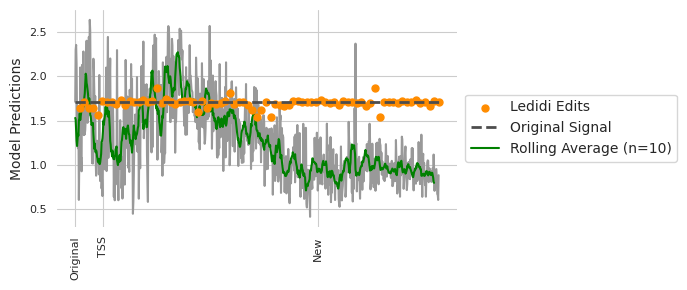

Rolling Average At New Site: 0.9372
Ledidi at New Site: 1.709


In [18]:
y0 = predict(model, X)[0, 0].item()
y1 = predict(model, X_bar3)[0, 0].item()

y_roll = numpy.cumsum(y_move)
y_roll = (y_roll[10:] - y_roll[:-10]) / 10.

plt.figure(figsize=(7, 3))
plt.scatter(range(10, 801, 10), y_ledidi, color='darkorange', s=25, label="Ledidi Edits", zorder=4)
plt.plot(y_move, c='0.6')
plt.plot([0, len(y_move)], [y0, y0], linewidth=2, linestyle='--', c='0.3', label="Original Signal", zorder=5)
plt.plot(y_roll, c='g', label="Rolling Average (n=10)")

plt.xticks([0, 1057-start, 1530-start], ['Original', 'TSS', 'New'], rotation=90, fontsize=8)
plt.ylabel("Model Predictions")
plt.yticks(fontsize=8)

plt.legend(loc=(1.02, 0.3))
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

print("Rolling Average At New Site: {:4.4}".format(y_roll[1530-start]))
print("Ledidi at New Site: {:4.4}".format(y_ledidi[(1530-start) // 10 - 1]))

It looks like there is a pretty large variance in CTCF predictions depending on the precise location that one makes the swap, even if we take a rolling average to smooth some of this out. In contrast, Ledidi is able to not only preserve the CTCF predictions on average but the variance is pretty low despite the variability in the baseline. An important note is that we are using the same model to evaluate the designs as we are using for the design itself. But the point still stands that something which intuitively might make sense at first blush, e.g., moving a motif a little bit along should keep the binding the same, might not actually be true. Using an explicit design method, like Ledidi, will allow you to automatically tune the affinity and surrounding context regardless of where you want to put the region.

Returning to the original question: if we had simply swapped copy/pasted the original sequence into the landing pad (denoted "new" in the above figure) we would have half the predicted CTCF binding as originally. If we use Ledidi to do the swap we get the same value.

We initially motivated this specific example by saying that you may want to move a motif because it interferes with transcription. As a final step, let's return to this hypothesis and see if moving the CTCF motif increases predicted transcription according to Enformer.

In [19]:
import os
os.environ['POLARS_ALLOW_FORKING_THREAD'] = '1' # Need this for Enformer

from enformer_pytorch import from_pretrained

class EnformerWrapper(torch.nn.Module):
    def __init__(self, model):
        super(EnformerWrapper, self).__init__()
        self.model = model

    def forward(self, X):
        y = self.model(X.permute(0, 2, 1))['human']
        return torch.log(y.sum(dim=1) + 1)

enformer = from_pretrained('EleutherAI/enformer-official-rough', target_length=16, use_tf_gamma=False)
enformer = EnformerWrapper(enformer).eval().cuda()

predict(enformer, X)[:, 5111], predict(enformer, X_bar3)[:, 5111].mean()

(tensor([5.8661]), tensor(5.9624))

Looks like removing the CTCF site does increase the CAGE predictions a little bit at this region. it is true that this may not fundamentally change activity at the locus but in settings where subtle changes might matter, such as designing cell type-specific elements that rely on sub-optimal spacings, diminishing or increasing transcription by a little bit might be helpful!